# Community Analysis and Visualization of Cluster Data (2025 Projections)

This notebook performs community analysis and visualization of cluster data for 2025 projections.

## Key Steps

1. Loads required libraries including pandas, networkx, plotly and matplotlib
2. Sets up environment variables and paths for data/output directories
3. Reads graph data from graphml file containing community structure
4. Loads analysis dataframe with cluster assignments
5. Processes cluster labels and qualifications data
6. Creates visualizations of:
   - Community proportions and trends
   - Cluster relationships and structure
   - Distribution of qualifications across clusters

The notebook uses custom plotting classes (StaticProportionsPlotter) to generate standardized visualizations of the community analysis results.


In [1]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# remove the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

from dotenv import load_dotenv
import os
# Load environment variables from .env file
load_dotenv()

# Access environment variables
python_path = os.getenv('PYTHONPATH')
data_dir = os.getenv('DATA_DIR')
src_dir = os.getenv('SRC_DIR')
output_dir = os.getenv('OUTPUT_DIR')


In [2]:

pg = data_dir + "/08-analysis-data/2025/graph_analysis.graphml"
G = nx.read_graphml(pg)
pdf = data_dir + "/08-analysis-data/2025/df_analysis.pkl"
df = pd.read_pickle(pdf)


In [3]:
# open the cluster label file

with open(
    output_dir + "/cluster-qualifications_2025/cluster-label-tree/cluster_labels_filtered.json",
    "r",
) as f:
    cluster_label_dict = json.load(f)


# read in legend
legend_p = output_dir + "/cluster-qualifications_2025/cluster-label-tree/legend_labels_2025.json"
with open(legend_p, "r") as f:
    legend = json.load(f)


Get geriatrics clusters from legend


In [ ]:
cluster_label_dict[4]


KeyError: 4

In [ ]:

geriatrics_keys = []
for item in legend['Safety']['Perinatal Exposure']:
    if isinstance(item, dict):
        geriatrics_keys.extend([int(k) for k in item.keys()])
    else:
        geriatrics_keys.append(int(item))

print('The Clusters are:')
for key in geriatrics_keys:
    print(f"{key}  : {cluster_label_dict[str(key)]}")


The Clusters are:
4  : Risk of Prenatal Exposure
10  : Risk of Prenatal Exposure (Rodents)
42  : SSRI Effects on Lactation
95  : SSRIs for Postpartum Depression


# VISUALS


# Interactive visualization


In [15]:
import logging
from pathlib import Path
from typing import Any, Dict, List, Literal, Optional, Tuple, Union

import numpy as np
import pandas as pd
import plotly.express as px
from plotly.graph_objects import Figure


class InteractiveProportionsPlotter:
    """
    A class to visualize cluster proportions over time using Plotly.

    This class provides functionality to create interactive area plots showing
    how the proportion of different clusters changes over time.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        cluster_label_dict: Dict[str, str],
        year_col: str = "year",
        cluster_col: str = "cluster_alpha0.3_k10_res0.002",
        output_dir: Optional[str] = None
    ) -> None:
        """
        Initialize the plotter with the necessary data.

        Args:
            df: DataFrame containing the cluster data
            cluster_label_dict: Dictionary mapping cluster IDs to readable labels
            year_col: Column name for the year data
            cluster_col: Column name for the cluster assignments
            output_dir: Directory to save output figures (None for no default directory)

        Raises:
            ValueError: If required columns are missing or data types are incompatible
        """
        # Set up logging
        self.logger = logging.getLogger(__name__)

        # Validate input data
        self._validate_dataframe(df, year_col, cluster_col)
        self._validate_cluster_dict(cluster_label_dict)

        # Store validated data
        self.df = df.copy()
        self.year_col = year_col
        self.cluster_col = cluster_col
        self.cluster_label_dict = cluster_label_dict
        self.output_dir = Path(output_dir) if output_dir else None

        # Ensure cluster column is string type for consistent comparisons
        if not pd.api.types.is_string_dtype(self.df[self.cluster_col]):
            self.df[self.cluster_col] = self.df[self.cluster_col].apply(
                lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x)
            )
            self.logger.info(f"Converted {self.cluster_col} to string type for consistent comparisons")

    def _validate_dataframe(self, df: pd.DataFrame, year_col: str, cluster_col: str) -> None:
        """
        Validate the input DataFrame has the required columns and correct data types.

        Args:
            df: DataFrame to validate
            year_col: Year column name
            cluster_col: Cluster column name

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError(f"Expected pandas DataFrame, got {type(df)}")

        # Check required columns exist
        missing_cols = [col for col in [year_col, cluster_col] if col not in df.columns]
        if missing_cols:
            raise ValueError(f"DataFrame missing required columns: {missing_cols}")

        # Validate year column
        if not pd.api.types.is_numeric_dtype(df[year_col]):
            raise ValueError(f"Year column '{year_col}' must be numeric")

        # Ensure cluster column can be converted to string
        try:
            _ = df[cluster_col].astype(str)
        except Exception as e:
            raise ValueError(f"Could not convert cluster column to string: {e}")

    def _validate_cluster_dict(self, cluster_dict: Dict[str, str]) -> None:
        """
        Validate the cluster label dictionary.

        Args:
            cluster_dict: Dictionary mapping cluster IDs to labels

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(cluster_dict, dict):
            raise ValueError(f"Expected dict for cluster_label_dict, got {type(cluster_dict)}")

        # Check that all keys can be converted to strings for consistent comparisons
        try:
            {str(k): v for k, v in cluster_dict.items()}
        except Exception as e:
            raise ValueError(f"Cluster dictionary keys must be convertible to strings: {e}")

    def _generate_distinct_colors(self, num_colors: int) -> List[str]:
        """
        Generate a list of perceptually distinct colors in hex format for Plotly.

        Uses the HSV color space with evenly spaced hues and carefully selected
        saturation and value to ensure maximum visual distinction.

        Args:
            num_colors: Number of distinct colors to generate

        Returns:
            List of hex color codes
        """
        colors = []

        # Use golden ratio to generate well-spaced hues
        golden_ratio_conjugate = 0.618033988749895

        # Start at a random point
        h = np.random.random()

        # Generate colors with varying hue but consistent saturation and value
        for i in range(num_colors):
            # Shift the hue by the golden ratio
            h += golden_ratio_conjugate
            h %= 1.0

            # HSV (hue, saturation, value) - vary saturation and value slightly
            # to enhance distinguishability
            if i % 3 == 0:
                # Use high saturation and value
                s = 0.8
                v = 0.9
            elif i % 3 == 1:
                # Use high saturation but lower value (darker)
                s = 0.9
                v = 0.7
            else:
                # Use lower saturation but high value (lighter, pastel-like)
                s = 0.65
                v = 0.85

            # Convert HSV to RGB
            r, g, b = self._hsv_to_rgb(h, s, v)

            # Convert RGB to hex
            hex_color = f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
            colors.append(hex_color)

        return colors

    def _hsv_to_rgb(self, h: float, s: float, v: float) -> Tuple[float, float, float]:
        """
        Convert HSV color to RGB.

        Args:
            h: Hue (0-1)
            s: Saturation (0-1)
            v: Value (0-1)

        Returns:
            RGB tuple with values in range 0-1
        """
        if s == 0.0:
            return (v, v, v)

        i = int(h * 6)  # Sector 0 to 5
        f = (h * 6) - i  # Factorial part of h
        p = v * (1 - s)
        q = v * (1 - s * f)
        t = v * (1 - s * (1 - f))

        if i % 6 == 0:
            return (v, t, p)
        elif i % 6 == 1:
            return (q, v, p)
        elif i % 6 == 2:
            return (p, v, t)
        elif i % 6 == 3:
            return (p, q, v)
        elif i % 6 == 4:
            return (t, p, v)
        else:
            return (v, p, q)

    def _get_optimized_color_palette(self, num_colors: int, color_palette: Optional[List[str]] = None) -> List[str]:
        """
        Get an optimized color palette with maximally distinct colors.

        Args:
            num_colors: Number of colors needed
            color_palette: Optional user-provided color palette

        Returns:
            List of hex color codes
        """
        # If a specific palette is provided, use it
        if color_palette and len(color_palette) >= num_colors:
            return color_palette[:num_colors]

        # Use preset qualitative palettes for common cases
        if num_colors <= 10:
            # Use Plotly's qualitative palette which has good distinction for up to 10 colors
            # This is better than D3 for small sets as it has more distinct hues
            return px.colors.qualitative.Plotly[:num_colors]
        elif num_colors <= 12:
            # Use the Set3 qualitative palette which has good distinction for up to 12 colors
            return px.colors.qualitative.Set3[:num_colors]
        elif num_colors <= 26:
            # Alphabetical color palette has 26 distinct colors
            return px.colors.qualitative.Alphabet[:num_colors]
        else:
            # For larger sets, generate algorithmically with golden ratio method
            return self._generate_distinct_colors(num_colors)

    def plot_proportions(
        self,
        cluster_subset_list: List[Union[str, int, float]],
        figsize: Tuple[int, int] = (10, 6),
        proportions_total: Literal["total", "subset"] = "total",
        save: bool = False,
        filename: Optional[str] = None,
        color_palette: Optional[List[str]] = None,
        title: Optional[str] = None,
        show_buttons: bool = True,
        year_range: Optional[Tuple[int, int]] = None,
        plot_type: Literal["area", "line"] = "area",
        sort_clusters: bool = False
    ) -> Figure:
        """
        Plot cluster proportions over time as an interactive area chart.

        Args:
            cluster_subset_list: List of cluster IDs to include in the plot
            figsize: Size of the figure as (width, height) in inches
            proportions_total: Whether to calculate proportions relative to "total" data or "subset" only
            save: Whether to save the figure
            filename: Custom filename for the saved figure (default: cluster_proportions_YYYY.html)
            color_palette: Custom color palette for the plot
            title: Custom title for the plot
            show_buttons: Whether to show the select/deselect all buttons
            year_range: Optional tuple of (start_year, end_year) to filter the data
            plot_type: "area" for stacked area plot or "line" for line plot
            sort_clusters: Whether to sort clusters by their total proportion (large to small)

        Returns:
            A plotly Figure object

        Raises:
            ValueError: If input parameters are invalid
        """
        # Validate inputs
        if not cluster_subset_list:
            raise ValueError("cluster_subset_list cannot be empty")

        if proportions_total not in ["total", "subset"]:
            raise ValueError(f"proportions_total must be 'total' or 'subset', got '{proportions_total}'")

        if plot_type not in ["area", "line"]:
            raise ValueError(f"plot_type must be 'area' or 'line', got '{plot_type}'")

        # Convert all cluster IDs to strings for consistent comparison
        cluster_subset_strings = []
        for cluster_id in cluster_subset_list:
            if isinstance(cluster_id, float) and cluster_id.is_integer():
                cluster_subset_strings.append(str(int(cluster_id)))
            else:
                cluster_subset_strings.append(str(cluster_id))

        # Process year range filter if provided
        filtered_df = self.df
        if year_range:
            if not (isinstance(year_range, tuple) and len(year_range) == 2):
                raise ValueError("year_range must be a tuple of (start_year, end_year)")
            start_year, end_year = year_range
            filtered_df = filtered_df[(filtered_df[self.year_col] >= start_year) &
                                    (filtered_df[self.year_col] <= end_year)]
            if filtered_df.empty:
                raise ValueError(f"No data found for year range {year_range}")

        # Group and count clusters by year
        cluster_counts = (
            filtered_df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )

        # Filter to only include the requested clusters
        subset_cluster_counts = cluster_counts[
            cluster_counts[self.cluster_col].isin(cluster_subset_strings)
        ]

        if subset_cluster_counts.empty:
            clusters_in_df = sorted(cluster_counts[self.cluster_col].unique())
            raise ValueError(f"No data found for specified clusters. Available clusters: {clusters_in_df}")

        # Calculate yearly totals for normalization based on the chosen method
        if proportions_total == "total":
            yearly_totals = cluster_counts.groupby(self.year_col)["count"].transform("sum")
            y_label = "Proportion of Total Papers"
        else:  # "subset"
            yearly_totals = subset_cluster_counts.groupby(self.year_col)["count"].transform("sum")
            y_label = "Proportion of Selected Clusters"

        # Calculate proportions
        subset_cluster_counts["proportion"] = subset_cluster_counts["count"] / yearly_totals

        # Sort clusters by their total proportion if requested
        if sort_clusters:
            # Calculate total proportion for each cluster across all years
            cluster_total_props = subset_cluster_counts.groupby(self.cluster_col)["proportion"].sum().reset_index()
            cluster_total_props = cluster_total_props.sort_values("proportion", ascending=False)

            # Create a ordered list of clusters
            sorted_clusters = cluster_total_props[self.cluster_col].tolist()
        else:
            # Just get unique clusters in their original order
            sorted_clusters = subset_cluster_counts[self.cluster_col].unique().tolist()

        # Reshape data for plotting
        pivot_df = (
            subset_cluster_counts.pivot(
                index=self.year_col, columns=self.cluster_col, values="proportion"
            )
            .fillna(0)
        )

        # Make sure columns are in the desired order
        available_clusters = [c for c in sorted_clusters if c in pivot_df.columns]
        pivot_df = pivot_df[available_clusters]

        # Melt the data back for plotly
        long_df = (
            pivot_df.reset_index()
            .melt(id_vars=[self.year_col], var_name="Cluster", value_name="Proportion")
        )

        # Ensure cluster labels are strings
        long_df["Cluster"] = long_df["Cluster"].astype(str)

        # Apply cluster labels from dictionary, with fallback for missing labels
        long_df["Cluster_Label"] = long_df["Cluster"].apply(
            lambda x: self.cluster_label_dict.get(x, f"Cluster {x}")
        )

        # Order the clusters by their total proportion
        if sort_clusters:
            # Create a category order based on our sorting
            cluster_category_order = {
                cluster: i for i, cluster in enumerate(sorted_clusters)
            }

            # Add a sort order column
            long_df["cluster_order"] = long_df["Cluster"].map(
                lambda x: cluster_category_order.get(x, len(sorted_clusters))
            )

            # Sort the dataframe
            long_df = long_df.sort_values("cluster_order")

        # Set default title if none provided
        if title is None:
            title = "Cluster Proportions Over Time"
            if proportions_total == "subset":
                title += " (Relative to Selected Clusters)"

        # Get an optimized color palette
        num_clusters = len(long_df["Cluster"].unique())
        optimized_colors = self._get_optimized_color_palette(num_clusters, color_palette)

        # Create the plot based on the requested type
        if plot_type == "area":
            fig = px.area(
                long_df,
                x=self.year_col,
                y="Proportion",
                color="Cluster_Label",
                title=title,
                labels={self.year_col: "Year", "Proportion": y_label},
                width=figsize[0] * 100,
                height=figsize[1] * 100,
                color_discrete_sequence=optimized_colors,
            )
        else:  # line plot
            fig = px.line(
                long_df,
                x=self.year_col,
                y="Proportion",
                color="Cluster_Label",
                title=title,
                labels={self.year_col: "Year", "Proportion": y_label},
                width=figsize[0] * 100,
                height=figsize[1] * 100,
                color_discrete_sequence=optimized_colors,
                line_shape="spline",  # smooth lines
                render_mode="svg",    # better quality
                line_width=3,         # thicker lines for clarity
            )

        # Add hover data to show actual counts
        fig.update_traces(
            hovertemplate="<b>%{fullData.name}</b><br>Year: %{x}<br>Proportion: %{y:.2%}<extra></extra>"
        )

        # Format Y-axis as percentage
        fig.update_layout(
            yaxis=dict(
                tickformat=".1%",
                title=dict(font=dict(size=14)),
            ),
            xaxis=dict(
                title=dict(font=dict(size=14)),
            ),
            title=dict(font=dict(size=18)),
            legend=dict(
                title=dict(text="Cluster", font=dict(size=14)),
                font=dict(size=12),
                # Always place legend on the right side with one column
                orientation="v",
                yanchor="top",
                y=1,
                xanchor="left",
                x=1.02,
                # Single column
                traceorder="normal",
            ),
            plot_bgcolor="white",
            hovermode="closest",
            # Adjust margins to make room for the legend
            margin=dict(r=150 if num_clusters <= 15 else 200),
        )

        # Add scrolling to legend if we have many clusters
        if num_clusters > 15:
            fig.update_layout(
                legend=dict(
                    # Enable scrolling for large legend sets
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor="rgba(255, 255, 255, 0.8)",
                    bordercolor="rgba(0, 0, 0, 0.2)",
                    borderwidth=1,
                )
            )

        # Add select/deselect buttons if requested
        if show_buttons:
            buttons = [
                dict(
                    args=[{"visible": "legendonly"}],
                    label="Deselect All",
                    method="restyle",
                ),
                dict(
                    args=[{"visible": True}],
                    label="Select All",
                    method="restyle",
                ),
            ]

            # Add option to show by proportion size
            if sort_clusters and num_clusters > 5:
                # Create a "Show Top 5" button
                visible_list = ["legendonly"] * num_clusters
                for i in range(min(5, num_clusters)):
                    visible_list[i] = True

                buttons.append(
                    dict(
                        args=[{"visible": visible_list}],
                        label="Show Top 5",
                        method="restyle",
                    )
                )

            fig.update_layout(
                updatemenus=[
                    dict(
                        type="buttons",
                        direction="left",
                        buttons=buttons,
                        pad={"r": 10, "t": 10},
                        showactive=False,
                        x=1,
                        xanchor="right",
                        y=1.1,
                        yanchor="top",
                    ),
                ]
            )

        # Save the figure if requested
        if save:
            if self.output_dir is None and filename is None:
                self.logger.warning("Cannot save figure: no output directory or filename specified")
            else:
                save_path = self._get_save_path(filename)
                try:
                    fig.write_html(save_path)
                    self.logger.info(f"Figure saved to {save_path}")
                except Exception as e:
                    self.logger.error(f"Failed to save figure: {e}")

        return fig

    def plot_comparison(
        self,
        clusters_list: List[List[Union[str, int, float]]],
        periods: List[Tuple[int, int]],
        titles: Optional[List[str]] = None,
        figsize: Tuple[int, int] = (12, 8),
        proportions_total: Literal["total", "subset"] = "total",
        color_palette: Optional[List[str]] = None,
        plot_type: Literal["area", "line"] = "area",
        grid: bool = True,
        shared_legend: bool = True,
        shared_yaxis: bool = True,
        save: bool = False,
        filename: Optional[str] = None,
    ) -> Figure:
        """
        Create a multi-panel comparison of cluster proportions across different time periods.

        Args:
            clusters_list: List of cluster ID lists for each subplot (or single list for all)
            periods: List of (start_year, end_year) tuples defining each time period
            titles: Optional titles for each subplot
            figsize: Size of the figure as (width, height) in inches
            proportions_total: Whether to calculate proportions relative to "total" data or "subset" only
            color_palette: Custom color palette for the plot
            plot_type: "area" for stacked area plot or "line" for line plot
            grid: Whether to display grid lines
            shared_legend: Whether to use a single legend for all subplots
            shared_yaxis: Whether to use the same y-axis scale for all subplots
            save: Whether to save the figure
            filename: Custom filename for the saved figure

        Returns:
            A plotly Figure object

        Raises:
            ValueError: If input parameters are invalid
        """
        import plotly.subplots as sp

        # Validate inputs
        if not periods:
            raise ValueError("periods cannot be empty")

        num_periods = len(periods)

        # Handle single cluster list for all periods
        if isinstance(clusters_list[0], (str, int, float)) or len(clusters_list) == 1:
            clusters_list = [clusters_list] * num_periods
        elif len(clusters_list) != num_periods:
            raise ValueError(f"Length of clusters_list ({len(clusters_list)}) must match periods ({num_periods})")

        # Generate default titles if not provided
        if titles is None:
            titles = [f"Period {start_year}-{end_year}" for start_year, end_year in periods]
        elif len(titles) != num_periods:
            raise ValueError(f"Length of titles ({len(titles)}) must match periods ({num_periods})")

        # Calculate optimal subplot layout
        if num_periods <= 2:
            rows, cols = 1, num_periods
        else:
            cols = min(3, num_periods)
            rows = (num_periods + cols - 1) // cols  # Ceiling division

        # Create subplot figure
        fig = sp.make_subplots(
            rows=rows,
            cols=cols,
            subplot_titles=titles,
            shared_yaxes=shared_yaxis,
            vertical_spacing=0.1,
        )

        # Track all unique clusters across all panels for consistent coloring
        all_clusters = set()
        for cluster_subset in clusters_list:
            for cluster in cluster_subset:
                if isinstance(cluster, float) and cluster.is_integer():
                    all_clusters.add(str(int(cluster)))
                else:
                    all_clusters.add(str(cluster))

        # Get optimized color palette for all clusters
        color_map = {}
        optimized_colors = self._get_optimized_color_palette(len(all_clusters), color_palette)
        for i, cluster in enumerate(sorted(all_clusters)):
            # Get the cluster label
            label = self.cluster_label_dict.get(cluster, f"Cluster {cluster}")
            # Assign a color
            color_map[label] = optimized_colors[i % len(optimized_colors)]

        # Track all traces for shared legend
        all_traces = {}

        # Create each subplot
        for i, (period, cluster_subset) in enumerate(zip(periods, clusters_list)):
            # Calculate row and column for this subplot
            row = (i // cols) + 1
            col = (i % cols) + 1

            # Filter data for this period
            year_range = period

            # Create the individual plot
            subfig = self.plot_proportions(
                cluster_subset_list=cluster_subset,
                figsize=figsize,
                proportions_total=proportions_total,
                save=False,
                color_palette=optimized_colors,  # Use the same palette for consistency
                title=None,  # We'll use subplot_titles
                show_buttons=False,  # We'll add these to the main figure
                year_range=year_range,
                plot_type=plot_type,
            )

            # Extract traces from the subfigure and add to main figure
            for trace in subfig.data:
                cluster_label = trace.name

                # For shared legend, only add unique traces
                if shared_legend:
                    if cluster_label in all_traces:
                        # Add to figure without adding to legend
                        trace.showlegend = False
                    else:
                        # Add to our tracking dict
                        all_traces[cluster_label] = True

                # Set consistent colors based on cluster label
                if cluster_label in color_map:
                    trace.marker.color = color_map[cluster_label]
                    if hasattr(trace, 'line'):
                        trace.line.color = color_map[cluster_label]

                # Add the trace to the main figure
                fig.add_trace(trace, row=row, col=col)

            # Copy layout settings from subfigure
            fig.update_xaxes(
                title_text="Year" if row == rows else None,
                row=row,
                col=col,
                tickformat=subfig.layout.xaxis.tickformat,
            )

            # Only add y-axis title to leftmost subplots
            if col == 1:
                fig.update_yaxes(
                    title_text=subfig.layout.yaxis.title.text,
                    row=row,
                    col=col,
                    tickformat='.1%',  # Percentage format
                )
            else:
                fig.update_yaxes(
                    tickformat='.1%',  # Percentage format
                    row=row,
                    col=col,
                )

            # Add grid if requested
            if grid:
                fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgray", row=row, col=col)
                fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgray", row=row, col=col)

        # Update overall figure layout
        fig.update_layout(
            width=figsize[0] * 100 * cols,
            height=figsize[1] * 100 * rows,
            title_text="Cluster Proportions Comparison",
            plot_bgcolor="white",
            hovermode="closest",
        )

        # For shared legend with many clusters, place at the right
        fig.update_layout(
            legend=dict(
                orientation="v",
                yanchor="top",
                y=1,
                xanchor="left",
                x=1.02,
                # Add a border for visibility
                bgcolor="rgba(255, 255, 255, 0.8)",
                bordercolor="rgba(0, 0, 0, 0.2)",
                borderwidth=1,
            ),
            # Adjust margins to make room for the legend
            margin=dict(r=150 if len(all_clusters) <= 15 else 200),
        )

        # Add scrolling to legend if we have many clusters
        if len(all_clusters) > 15:
            fig.update_layout(
                legend=dict(
                    # Enable scrolling for large legend sets
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                )
            )

        # Add buttons for manipulating all traces
        if num_periods > 1:
            fig.update_layout(
                updatemenus=[
                    dict(
                        type="buttons",
                        direction="left",
                        buttons=list(
                            [
                                dict(
                                    args=[{"visible": "legendonly"}],
                                    label="Deselect All",
                                    method="restyle",
                                ),
                                dict(
                                    args=[{"visible": True}],
                                    label="Select All",
                                    method="restyle",
                                ),
                            ]
                        ),
                        pad={"r": 10, "t": 10},
                        showactive=False,
                        x=1,
                        xanchor="right",
                        y=1.05,
                        yanchor="top",
                    ),
                ]
            )

        # Save the figure if requested
        if save:
            if self.output_dir is None and filename is None:
                self.logger.warning("Cannot save figure: no output directory or filename specified")
            else:
                save_path = self._get_save_path(filename)
                try:
                    fig.write_html(save_path)
                    self.logger.info(f"Figure saved to {save_path}")
                except Exception as e:
                    self.logger.error(f"Failed to save figure: {e}")

        return fig

    def _get_save_path(self, filename: Optional[str] = None) -> str:
        """
        Get the full path for saving a figure.

        Args:
            filename: Optional custom filename

        Returns:
            Path to save the figure

        Raises:
            ValueError: If no output directory is set and no filename with path is provided
        """
        if filename and Path(filename).is_absolute():
            # If an absolute path is provided, use it directly
            return filename

        if self.output_dir is None:
            if filename is None:
                raise ValueError("No output directory set and no filename provided")
            # Use filename relative to current directory
            return filename

        # Make sure the output directory exists
        self.output_dir.mkdir(parents=True, exist_ok=True)

        # Generate default filename if none provided
        if filename is None:
            # Get the max year from the data for the filename
            max_year = self.df[self.year_col].max()
            filename = f"cluster_proportions_{max_year}.html"

        # Return full path
        return str(self.output_dir / filename)


In [17]:

# Create plotter
plotter = InteractiveProportionsPlotter(
    df=df,
    cluster_label_dict=cluster_label_dict,
    year_col="year",
    cluster_col='cluster_alpha0.3_k10_res0.002',
    output_dir="./figures"
)

# Plot with all clusters, normalized by total
fig1 = plotter.plot_proportions(
    cluster_subset_list= df['cluster_alpha0.3_k10_res0.002'].unique().tolist(),
    figsize=(15, 8),
    proportions_total="total",
    save=True,
    title="Distribution of Research Topics Over Time"
)

# Plot with subset of clusters, normalized by subset
fig2 = plotter.plot_proportions(
    cluster_subset_list=geriatrics_keys,  # Only ML and CV
    figsize=(12, 6),
    proportions_total="total",
    save=True,
    filename="ml_cv_trends.html",
    color_palette=["#1f77b4", "#ff7f0e"]  # Custom colors
)


# Plot with subset of clusters, normalized by subset
fig2_subset = plotter.plot_proportions(
    cluster_subset_list=geriatrics_keys,  # Only ML and CV
    figsize=(12, 6),
    proportions_total="subset",
    save=True,
    filename="ml_cv_trends.html",
    color_palette=["#1f77b4", "#ff7f0e"]  # Custom colors
)


In [18]:
fig1


In [ ]:
fig2


In [ ]:
fig2_subset


# StaticProportionsPlotter


In [20]:
%matplotlib inline
from typing import Dict, List, Tuple, Union, Optional, Literal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from pathlib import Path


class StaticProportionsPlotter:
    """
    A class to create static visualizations of cluster proportions over time.

    Features:
    - Plot with or without rolling means
    - Optimized color selection for better visual distinction
    - Cluster merging functionality
    - Flexible legend placement
    - Customizable styling options
    """

    def __init__(
        self,
        df: pd.DataFrame,
        cluster_label_dict: Dict[str, str],
        cluster_col: str = "cluster_alpha0.3_k10_res0.002",
        year_col: str = "year",
        font_name: str = "Arial",
        font_size: int = 26,
        cluster_mergers: Optional[List[Tuple[str, str]]] = None,
        output_dir: Optional[str] = None
    ):
        """
        Initialize the plotter with the necessary data.

        Args:
            df: DataFrame containing the cluster data
            cluster_label_dict: Dictionary mapping cluster IDs to readable labels
            cluster_col: Column name for the cluster assignments
            year_col: Column name for the year data
            font_name: Font family to use for the plot
            font_size: Base font size for the plot
            cluster_mergers: List of tuples (target_cluster, source_cluster) to merge
            output_dir: Directory to save output figures (None for no default directory)
        """
        # Set up logging
        self.logger = logging.getLogger(__name__)

        # Store initial parameters
        self.df = df.copy()
        self.cluster_label_dict = cluster_label_dict.copy()
        self.cluster_col = cluster_col
        self.year_col = year_col
        self.font_name = font_name
        self.font_size = font_size
        self.output_dir = Path(output_dir) if output_dir else None

        # Ensure cluster column is string type for consistent comparisons
        if not pd.api.types.is_string_dtype(self.df[self.cluster_col]):
            self.df[self.cluster_col] = self.df[self.cluster_col].apply(
                lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x)
            )
            self.logger.info(f"Converted {self.cluster_col} to string type for consistent comparisons")

        # Merge clusters if needed
        if cluster_mergers:
            self.merge_clusters(cluster_mergers)

        # Initialize cluster counts as None (will be calculated when needed)
        self.cluster_counts = None

        # Verify font availability
        self._check_font_availability()

    def _check_font_availability(self):
        """Check if the specified font is available, otherwise use a fallback."""
        available_fonts = set(f.name for f in fm.fontManager.ttflist)
        if self.font_name not in available_fonts:
            self.logger.warning(f"Font '{self.font_name}' not found. Using 'sans-serif' instead.")
            self.font_name = 'sans-serif'

    def merge_clusters(self, cluster_mergers: List[Tuple[str, str]]):
        """
        Merge clusters based on the specified list of tuples.

        Args:
            cluster_mergers: List of tuples (target_cluster, source_cluster)
                             where source_cluster will be replaced by target_cluster
        """
        for target, source in cluster_mergers:
            # Ensure both are strings for consistent comparison
            target_str = str(target)
            source_str = str(source)

            # Replace in DataFrame
            self.df[self.cluster_col] = self.df[self.cluster_col].replace({source_str: target_str})

            # Update label dictionary if needed
            if source_str in self.cluster_label_dict and target_str not in self.cluster_label_dict:
                self.cluster_label_dict[target_str] = self.cluster_label_dict[source_str]

        # Reset cluster counts since data has changed
        self.cluster_counts = None
        self.logger.info(f"Merged {len(cluster_mergers)} cluster pairs")

    def _calculate_cluster_proportions_per_year(self, year_range: Optional[Tuple[int, int]] = None):
        """
        Calculate counts and proportions of papers per cluster per year.

        Args:
            year_range: Optional tuple of (start_year, end_year) to filter the data
        """
        # Filter by year range if specified
        filtered_df = self.df
        if year_range:
            filtered_df = filtered_df[
                (filtered_df[self.year_col] >= year_range[0]) &
                (filtered_df[self.year_col] <= year_range[1])
            ]

        # Group by year and cluster to get counts
        cluster_counts = (
            filtered_df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )

        # Calculate yearly proportions
        cluster_counts["proportion"] = cluster_counts.groupby(self.year_col)["count"].transform(
            lambda x: x / x.sum()
        )

        self.cluster_counts = cluster_counts
        return cluster_counts

    def _calculate_subset_cluster_proportions_per_year(self, clusters_to_plot: List[str]):
        """
        Calculate proportions for a subset of clusters relative to that subset's total.

        Args:
            clusters_to_plot: List of cluster IDs to include

        Returns:
            DataFrame with proportions calculated relative to the subset total
        """
        # Ensure all cluster IDs are strings
        clusters_as_str = [str(c) for c in clusters_to_plot]

        # Filter to only the requested clusters
        filtered_counts = self.cluster_counts[
            self.cluster_counts[self.cluster_col].isin(clusters_as_str)
        ]

        if filtered_counts.empty:
            available_clusters = sorted(self.cluster_counts[self.cluster_col].unique())
            raise ValueError(
                f"No data found for specified clusters. Available clusters: {available_clusters}"
            )

        # Recalculate proportions based on the subset total
        filtered_counts["proportion"] = filtered_counts.groupby(self.year_col)["count"].transform(
            lambda x: x / x.sum()
        )

        return filtered_counts

    def _set_x_axis_ticks_and_limits(self, ax, years, rotation=45):
        """
        Set x-axis ticks and limits for better visualization.

        Args:
            ax: Matplotlib axis object
            years: Series or array of years in the data
            rotation: Rotation angle for x-tick labels
        """
        min_year = min(years)
        max_year = max(years)

        # Calculate an appropriate tick interval
        year_range = max_year - min_year
        if year_range <= 10:
            tick_interval = 1
        elif year_range <= 30:
            tick_interval = 5
        else:
            tick_interval = 10

        # Generate tick positions
        start_tick = (min_year // tick_interval) * tick_interval
        end_tick = ((max_year // tick_interval) + 1) * tick_interval
        ticks = np.arange(start_tick, end_tick + 1, tick_interval)

        # Ensure the min and max years are included
        if min_year not in ticks:
            ticks = np.insert(ticks, 0, min_year)
        if max_year not in ticks:
            ticks = np.append(ticks, max_year)

        # Set ticks and limits
        ax.set_xticks(ticks)
        buffer = year_range * 0.02  # Add 2% buffer on each side
        ax.set_xlim(min_year - buffer, max_year + buffer)

        # Rotate x labels if specified
        plt.xticks(rotation=rotation)

    def _generate_distinct_colors(self, num_colors: int) -> List:
        """
        Generate a list of perceptually distinct colors.

        Uses the HSV color space with evenly spaced hues and carefully selected
        saturation and value to ensure maximum visual distinction.

        Args:
            num_colors: Number of distinct colors to generate

        Returns:
            List of RGB colors as tuples
        """
        colors = []

        # Use golden ratio to generate well-spaced hues
        golden_ratio_conjugate = 0.618033988749895

        # Start at a random point (but fixed for reproducibility)
        h = 0.1  # Starting hue

        # Generate colors with varying hue but consistent saturation and value
        for i in range(num_colors):
            # Shift the hue by the golden ratio
            h += golden_ratio_conjugate
            h %= 1.0

            # HSV (hue, saturation, value) - vary saturation and value slightly
            # to enhance distinguishability
            if i % 3 == 0:
                # Use high saturation and value
                s = 0.8
                v = 0.9
            elif i % 3 == 1:
                # Use high saturation but lower value (darker)
                s = 0.85
                v = 0.7
            else:
                # Use lower saturation but high value (lighter, pastel-like)
                s = 0.65
                v = 0.85

            # Convert HSV to RGB
            rgb = self._hsv_to_rgb(h, s, v)
            colors.append(rgb)

        return colors

    def _hsv_to_rgb(self, h: float, s: float, v: float) -> Tuple[float, float, float]:
        """
        Convert HSV color to RGB.

        Args:
            h: Hue (0-1)
            s: Saturation (0-1)
            v: Value (0-1)

        Returns:
            RGB tuple with values in range 0-1
        """
        if s == 0.0:
            return (v, v, v)

        i = int(h * 6)  # Sector 0 to 5
        f = (h * 6) - i  # Factorial part of h
        p = v * (1 - s)
        q = v * (1 - s * f)
        t = v * (1 - s * (1 - f))

        if i % 6 == 0:
            return (v, t, p)
        elif i % 6 == 1:
            return (q, v, p)
        elif i % 6 == 2:
            return (p, v, t)
        elif i % 6 == 3:
            return (p, q, v)
        elif i % 6 == 4:
            return (t, p, v)
        else:
            return (v, p, q)

    def _get_optimized_colors(self, num_colors: int, color_palette: Optional[str] = None) -> List:
        """
        Get optimized colors for the plot.

        Args:
            num_colors: Number of colors needed
            color_palette: Optional matplotlib colormap name

        Returns:
            List of RGB color tuples
        """
        if color_palette and hasattr(plt.cm, color_palette):
            # Use the specified colormap
            cmap = getattr(plt.cm, color_palette)
            return [cmap(i / max(1, num_colors - 1)) for i in range(num_colors)]

        # Use qualitative colormaps for better distinction
        if num_colors <= 9:
            return plt.cm.Set1.colors[:num_colors]
        elif num_colors <= 12:
            return plt.cm.Paired.colors[:num_colors]
        elif num_colors <= 20:
            return plt.cm.tab20.colors[:num_colors]
        else:
            # For larger sets, generate algorithmically
            return self._generate_distinct_colors(num_colors)

    def plot_cluster_proportions(
        self,
        clusters_to_plot: List[Union[str, int, float]],
        rolling_window: Optional[int] = None,
        proportions_total: Literal["total", "subset"] = "total",
        figsize: Tuple[int, int] = (20, 8),
        color_palette: Optional[str] = None,
        title: Optional[str] = None,
        legend_loc: str = "right",
        legend_ncol: int = 1,
        year_range: Optional[Tuple[int, int]] = None,
        x_rotation: int = 45,
        show_grid: bool = True,
        save: bool = False,
        filename: Optional[str] = None,
        dpi: int = 300,
        format: str = "png",
        background_alpha: float = 0.5,
    ) -> Tuple[plt.Figure, plt.Axes]:
        """
        Plot cluster proportions over time with optional rolling means.

        Args:
            clusters_to_plot: List of cluster IDs to include in the plot
            rolling_window: Size of the rolling window for smoothing (None for no smoothing)
            proportions_total: Whether to calculate proportions relative to "total" data or "subset" only
            figsize: Size of the figure as (width, height) in inches
            color_palette: Name of a matplotlib colormap
            title: Custom title for the plot
            legend_loc: Location for the legend ('right', 'bottom', 'inside')
            legend_ncol: Number of columns in the legend
            year_range: Optional tuple of (start_year, end_year) to filter the data
            x_rotation: Rotation angle for x-axis labels
            show_grid: Whether to show grid lines
            save: Whether to save the figure
            filename: Custom filename for the saved figure
            dpi: Resolution in dots per inch for saved figure
            format: File format for saved figure
            background_alpha: Alpha transparency for background stackplot (if using rolling means)

        Returns:
            Tuple of (Figure, Axes) objects
        """
        # Completely isolate this figure from any previous state
        plt.close('all')  # Close all existing figures
        plt.rcParams.update(plt.rcParamsDefault)  # Reset all rcParams to default

        # Create a completely new figure with a clear backend state
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)  # Create a single axis

        # Ensure clusters are strings
        clusters_to_plot = [str(cluster) for cluster in clusters_to_plot]

        # Calculate proportions if not already done
        if self.cluster_counts is None:
            self._calculate_cluster_proportions_per_year(year_range)

        # Determine which proportions to use based on mode
        if proportions_total == "total":
            filtered_cluster_counts = self.cluster_counts.copy()
            yaxis_label = "Proportion (Overall)"
        else:  # "subset"
            filtered_cluster_counts = self._calculate_subset_cluster_proportions_per_year(clusters_to_plot)
            yaxis_label = "Proportion (Selected Clusters)"

        # Pivot to get clusters as columns
        pivot_df = filtered_cluster_counts.pivot(
            index=self.year_col, columns=self.cluster_col, values="proportion"
        ).fillna(0)

        # Filter to only include requested clusters and handle missing
        available_clusters = [c for c in clusters_to_plot if c in pivot_df.columns]
        if not available_clusters:
            raise ValueError(f"None of the requested clusters found in data. Available: {list(pivot_df.columns)}")

        pivot_df = pivot_df[available_clusters]

        # Calculate rolling means if requested
        if rolling_window and rolling_window > 1:
            pivot_df_rolling = pivot_df.rolling(window=rolling_window, min_periods=1).mean()
        else:
            pivot_df_rolling = pivot_df  # No rolling mean

        # Get human-readable labels
        cluster_labels = [
            self.cluster_label_dict.get(cluster, f"Cluster {cluster}")
            for cluster in available_clusters
        ]

        # Get optimized colors
        colors = self._get_optimized_colors(len(available_clusters), color_palette)

        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)

        # Convert all of the data needed for the plot to ensure no shared state
        pivot_df_data = pivot_df.copy()

        if rolling_window and rolling_window > 1:
            pivot_df_rolling_data = pivot_df_rolling.copy()
        else:
            pivot_df_rolling_data = pivot_df_data  # No rolling mean

        # Make local copies of all data to ensure complete isolation
        available_clusters_local = list(available_clusters)
        cluster_labels_local = list(cluster_labels)
        colors_local = list(colors)

        # Plot the data - different approaches for with/without rolling means
        if rolling_window and rolling_window > 1:
            # For rolling means, show both raw and smoothed data
            # Background stackplot shows raw data with transparency
            ax.stackplot(
                pivot_df_data.index,
                [pivot_df_data[col] for col in pivot_df_data.columns],
                labels=[],  # No labels for background
                colors=colors_local,
                alpha=background_alpha,
            )

            # Foreground stackplot shows smoothed data
            ax.stackplot(
                pivot_df_rolling_data.index,
                [pivot_df_rolling_data[col] for col in pivot_df_rolling_data.columns],
                labels=cluster_labels_local,
                colors=colors_local,
                alpha=1.0,  # Full opacity
            )

            if title is None:
                title = f"Cluster Proportions Over Time ({rolling_window}-Year Rolling Mean)"
        else:
            # Standard stackplot for non-smoothed data
            ax.stackplot(
                pivot_df_data.index,
                [pivot_df_data[col] for col in pivot_df_data.columns],
                labels=cluster_labels_local,
                colors=colors_local,
            )

            if title is None:
                title = "Cluster Proportions Over Time"

        # Set title if provided
        if title:
            ax.set_title(
                title,
                fontsize=self.font_size + 2,
                fontname=self.font_name,
                pad=20,
            )

        # Set axis labels
        ax.set_ylabel(
            yaxis_label,
            fontsize=self.font_size,
            fontname=self.font_name
        )
        ax.set_xlabel(
            "Year",
            fontsize=self.font_size,
            fontname=self.font_name
        )

        # Configure x-axis
        self._set_x_axis_ticks_and_limits(ax, pivot_df.index, rotation=x_rotation)

        # Add grid if requested
        if show_grid:
            ax.grid(True, linestyle='--', alpha=0.7)

        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

        # Position the legend based on specified location
        if legend_loc == "right":
            legend = ax.legend(
                title="Legend",
                bbox_to_anchor=(1.02, 1),
                loc="upper left",
                fontsize=self.font_size - 4,
                title_fontsize=self.font_size,
                ncol=legend_ncol,
                frameon=True,
                fancybox=True,
            )
            # Adjust layout for right legend
            plt.tight_layout()
            plt.subplots_adjust(right=0.8 if len(available_clusters) > 3 else 0.85)

        elif legend_loc == "bottom":
            legend = ax.legend(
                title="Legend",
                bbox_to_anchor=(0.5, -0.15),
                loc="upper center",
                fontsize=self.font_size - 4,
                title_fontsize=self.font_size,
                ncol=legend_ncol or min(3, len(available_clusters)),
                frameon=True,
                fancybox=True,
            )
            # Adjust layout for bottom legend
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.2 if len(available_clusters) > 3 else 0.15)

        else:  # "inside" or any other value
            legend = ax.legend(
                title="Legend",
                loc="best",
                fontsize=self.font_size - 4,
                title_fontsize=self.font_size,
                ncol=legend_ncol,
                frameon=True,
                fancybox=True,
                facecolor='white',
                alpha=0.8,
            )
            # Use standard tight layout
            plt.tight_layout()

        # Set font for tick labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname(self.font_name)
            label.set_fontsize(self.font_size - 4)

        # Save the figure if requested
        if save:
            save_path = self._get_save_path(filename, format)
            try:
                fig.savefig(save_path, dpi=dpi, bbox_inches="tight", format=format)
                self.logger.info(f"Figure saved to {save_path}")
            except Exception as e:
                self.logger.error(f"Failed to save figure: {e}")

        return fig, ax

    def _get_save_path(self, filename: Optional[str] = None, format: str = "png") -> str:
        """
        Get the full path for saving a figure.

        Args:
            filename: Optional custom filename
            format: File format extension

        Returns:
            Path to save the figure
        """
        if filename and Path(filename).is_absolute():
            # If an absolute path is provided, use it directly
            return filename

        if self.output_dir is None:
            if filename is None:
                # Default to current directory with timestamp
                import datetime
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                return f"cluster_proportions_{timestamp}.{format}"
            # Use filename relative to current directory
            return filename

        # Make sure the output directory exists
        self.output_dir.mkdir(parents=True, exist_ok=True)

        # Generate default filename if none provided
        if filename is None:
            # Get the max year from the data for the filename
            if hasattr(self, 'cluster_counts') and self.cluster_counts is not None:
                max_year = self.cluster_counts[self.year_col].max()
                filename = f"cluster_proportions_{max_year}"
            else:
                import datetime
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"cluster_proportions_{timestamp}"

        # Add extension if not present
        if not filename.lower().endswith(f".{format.lower()}"):
            filename = f"{filename}.{format.lower()}"

        # Return full path
        return str(self.output_dir / filename)






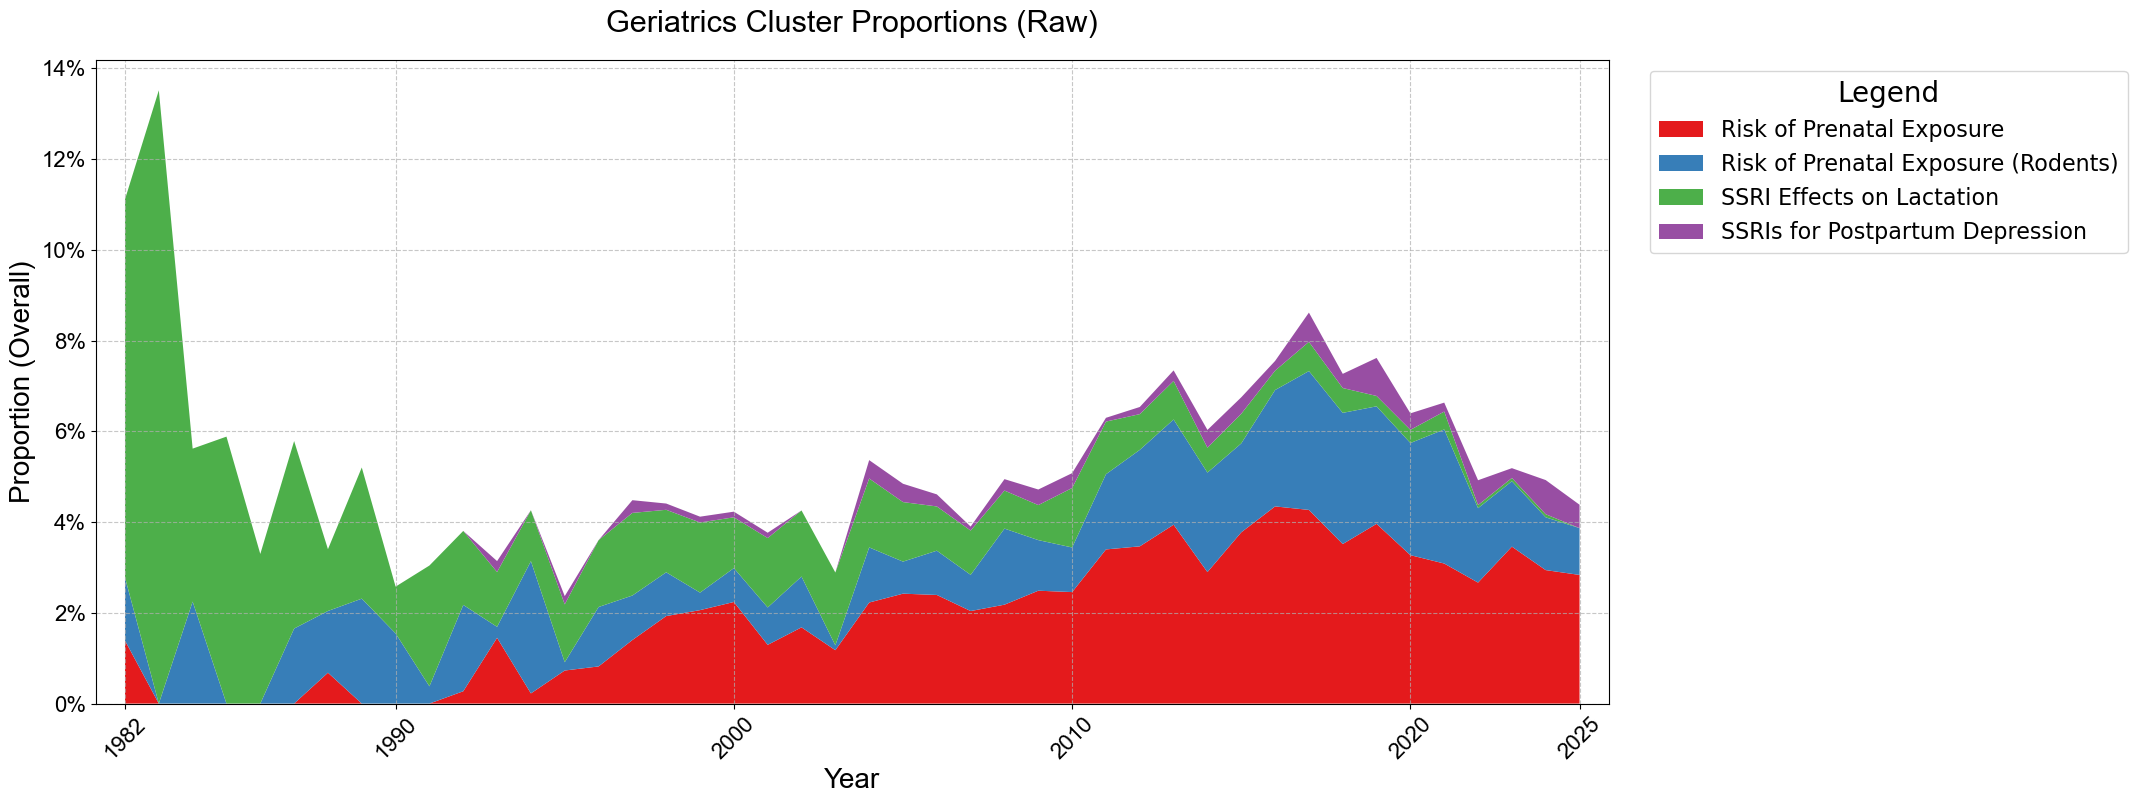

In [ ]:
# Initialize plotter
plotter = StaticProportionsPlotter(
    df=df,
    cluster_label_dict=cluster_label_dict,
    cluster_col='cluster_alpha0.3_k10_res0.002',
    font_size=20,
)

# Plot with raw data
fig1, ax1 = plotter.plot_cluster_proportions(
    clusters_to_plot=[str(i) for i in geriatrics_keys],
    rolling_window=None,  # No smoothing
    title="Geriatrics Cluster Proportions (Raw)",
    save=True,
    filename="geriatrics_raw.png"
)

fig1


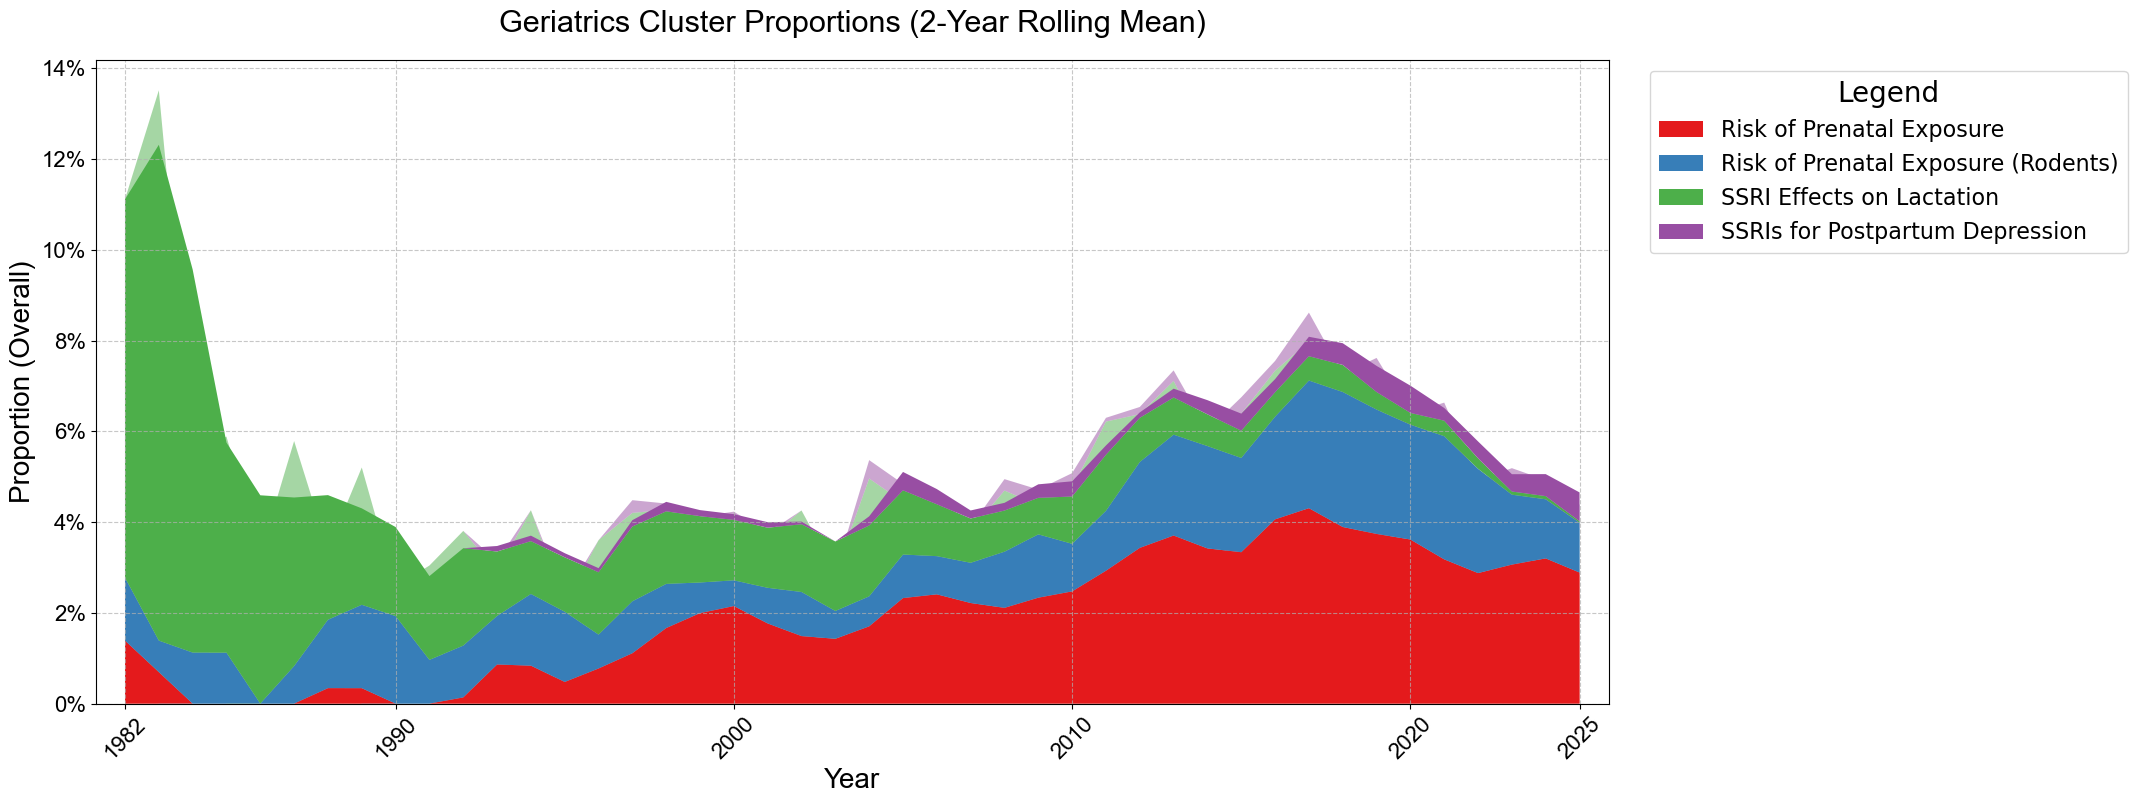

In [ ]:
# Initialize plotter
plotter2 = StaticProportionsPlotter(
    df=df,
    cluster_label_dict=cluster_label_dict,
    cluster_col='cluster_alpha0.3_k10_res0.002',
    font_size=20,
)

# Plot with rolling means
fig2, ax2 = plotter2.plot_cluster_proportions(
    clusters_to_plot=[str(i) for i in geriatrics_keys],
    rolling_window=2,  # 2-year smoothing
    title="Geriatrics Cluster Proportions (2-Year Rolling Mean)",
    save=True,
    filename="geriatrics_smoothed.png"
)

fig2
